In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import cvxpy as cp

In [2]:
np.random.seed(0)

In [3]:
expected_returns = np.array([.05, -.04])

covariance_matrix = np.array(
    [
        [.01, .1],
        [.1, .08]
     ]
)
covariance_matrix = covariance_matrix @ covariance_matrix.T

In [4]:
# Add safe asset to expected returns and covariance matrix
def add_safe_asset(returns, covariance_matrix):
    n = len(expected_returns)
    returns = np.concatenate([[0], returns])
    covariance_matrix = np.concatenate([np.zeros(shape=(1,n)), covariance_matrix]) # add row at the top
    covariance_matrix = np.concatenate([np.zeros(shape=(n+1, 1)), covariance_matrix], axis=1)
    return returns, covariance_matrix
    

In [5]:
expected_returns, covariance_matrix = add_safe_asset(expected_returns, covariance_matrix)
print(expected_returns)
print(covariance_matrix)


[ 0.    0.05 -0.04]
[[0.     0.     0.    ]
 [0.     0.0101 0.009 ]
 [0.     0.009  0.0164]]


In [6]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
print(eigenvalues)

[0.02278533 0.00371467 0.        ]


In [7]:
risk_parameter = .5

def find_markowitz_weights(expected_returns, covariance_matrix, risk_parameter):
    # Set ut the problem
    n = len(expected_returns)
    weights = cp.Variable(n)
    objective = cp.matmul(expected_returns, weights) - risk_parameter * cp.quad_form(weights, covariance_matrix)
    constraints = [cp.sum(weights) == 1, weights >= 0]
    prob = cp.Problem(cp.Maximize(objective), constraints)

    # Solving the problem
    prob.solve()
    return weights.value

In [8]:
optimal_weights = find_markowitz_weights(expected_returns, covariance_matrix, risk_parameter)

In [9]:
def get_wealth_trajectory_and_future_samples(historical_samples, sampling_function, steps):
    expected_returns = np.mean(historical_samples, axis=1)
    covariance_matrix = np.cov(historical_samples)

    weights = find_markowitz_weights(expected_returns, covariance_matrix, .5).reshape(-1, 1) #.5 is the risk parameter
    
    future_samples = np.maximum(sampling_function(steps).T, -1)

    portfolio_returns = np.zeros(steps)
    for step in range(steps):
        portfolio_returns[step] = (weights.T @ future_samples[:, step].reshape(-1, 1)).item()
        historical_samples = np.concatenate([historical_samples, future_samples[:, step].reshape(-1, 1)], axis=1)
        expected_returns = np.mean(historical_samples, axis=1)
        covariance_matrix = np.cov(historical_samples)
        weights = find_markowitz_weights(expected_returns, covariance_matrix, .5).reshape(-1, 1) #.5 is the risk parameter

    trajectory = ((1 + portfolio_returns)).cumprod()
    trajectory = np.concatenate([np.array([1.0]), trajectory]) # add a 1 so plots look like all trajectiries start with the same wealth
    trajectory = np.maximum(trajectory, 2**-80) # to prevent actually reaching 0 since we will use log scale in plots
    return trajectory, future_samples

def get_trajectory_given_return_samples_and_portfolio_weights(samples, weights):
    trajectory = (weights.T @ (1 + samples)).cumprod()
    trajectory = np.concatenate([np.array([1.0]), trajectory]) # add a 1 so plots look like all trajectiries start with the same wealth
    trajectory = np.maximum(trajectory, 2**-80) # to prevent actually reaching 0 since we will use log scale in plots
    return trajectory

In [10]:
optimal_weights = find_markowitz_weights(expected_returns, covariance_matrix, .5)

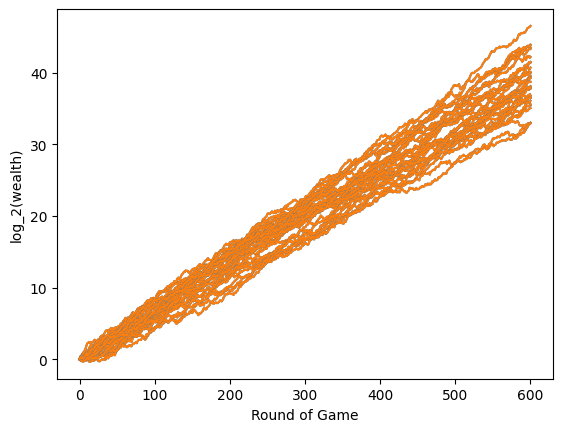

In [11]:
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
orange = (1.0, 0.4980392156862745, 0.054901960784313725)
np.random.seed(0)
number_of_initial_observation_periods = 24
samples_normal = stats.multivariate_normal.rvs(expected_returns, covariance_matrix, number_of_initial_observation_periods).T
rounds = 600
for i in range(30):
    trajectory, future_samples = get_wealth_trajectory_and_future_samples(samples_normal, lambda x: stats.multivariate_normal.rvs(expected_returns, covariance_matrix, x), rounds)
    optimal_trajectory = get_trajectory_given_return_samples_and_portfolio_weights(future_samples, optimal_weights)
    sns.lineplot(np.log2(trajectory), color =blue) 
    sns.lineplot(np.log2(optimal_trajectory), color = orange)
    plt.xlabel("Round of Game")
    plt.ylabel("log_2(wealth)")


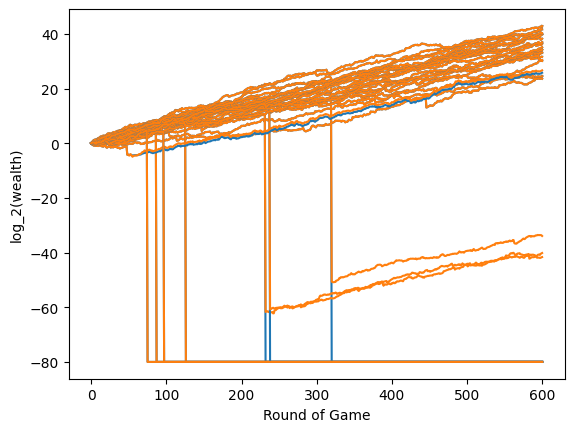

In [224]:
np.random.seed(2)
degrees_of_freedom = 4
assert(degrees_of_freedom > 2)
covariance_scaling_factor = (degrees_of_freedom-2)/(degrees_of_freedom) # Scaled Variance= df / (df−2) * Covariance Matrix
samples_t = stats.multivariate_t.rvs(expected_returns, covariance_scaling_factor * covariance_matrix, degrees_of_freedom, number_of_initial_observation_periods).T
for i in range(30):
    trajectory, future_samples = get_wealth_trajectory_and_future_samples(samples_t, lambda x: stats.multivariate_t.rvs(expected_returns, covariance_matrix, degrees_of_freedom, x), rounds)
    optimal_trajectory = get_trajectory_given_return_samples_and_portfolio_weights(future_samples, optimal_weights)
    sns.lineplot(np.log2(trajectory), color=blue) 
    sns.lineplot(np.log2(optimal_trajectory), color =orange)
    plt.xlabel("Round of Game")
    plt.ylabel("log_2(wealth)")

In [12]:
def find_kelly_weights(samples):
    samples = np.maximum(samples + 1, 2**-40) # set to -5 it works, but produces same solution as markov. with -40 solver crashes

    num_assets = samples.shape[0]
    weights = cp.Variable(num_assets)
    objective = cp.Maximize(cp.sum(cp.log(samples.T @ weights)))

    constraints = [cp.sum(weights) == 1, weights >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS)

    return weights.value

In [ ]:
covariance_scaling_factor = (degrees_of_freedom-2)/(degrees_of_freedom) # Scaled Variance= df / (df−2) * Covariance Matrix
# Make sure estimated covariance matrix looks like expected
print(np.cov(stats.multivariate_t.rvs(expected_returns, covariance_scaling_factor*covariance_matrix, degrees_of_freedom, 100000).T))
print(covariance_matrix)
# Next line will fail with high probability due to numerical issues
kelly_weights = find_kelly_weights(stats.multivariate_t.rvs(expected_returns, covariance_scaling_factor*covariance_matrix, degrees_of_freedom, 100000).T)